In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
matplotlib.rcParams.update({'font.size': 14})

## Read prepared B data for track-based and vertex-based tagging

In [3]:
import pandas
Bdata_tracks = pandas.read_csv('models/Bdata_tracks_MC.csv')
Bdata_vertex = pandas.read_csv('models/Bdata_vertex_MC_sqrt.csv')
Bdata_vertex_mike = pandas.read_csv('models/Bdata_vertices_MC_Mike.csv')

In [4]:
Bdata_tracks.head()

,Bsign,Bweight,event_id,track_relation_prob
0,-1,1,2498001_1,0.652731
1,1,1,2498001_10,1.892640
2,1,1,2498001_105,1.077080
3,1,1,2498001_108,0.985524
4,1,1,2498001_11,1.086548


In [5]:
Bdata_vertex.head()

,Bsign,Bweight,event_id,vertex_relation_prob
0,1,1,2498001_10,1.065763
1,1,1,2498001_108,1.126788
2,1,1,2498001_15,0.957585
3,-1,1,2498001_16,1.041989
4,-1,1,2498001_160,1.277399


In [6]:
Bdata_vertex_mike.head()

,Bsign,Bweight,event_id,vertex_relation_prob
0,1,1,2498001_10,1.176861
1,1,1,2498001_105,0.957777
2,1,1,2498001_108,1.152907
3,1,1,2498001_15,0.851757
4,-1,1,2498001_16,1.153730


### Merge two datasets

In [7]:
def prepare_B_data(Bdata_tracks, Bdata_vertex, only_track=False):
    Bdata = pandas.merge(Bdata_tracks, Bdata_vertex, how='outer', on=['event_id', 'Bsign'])
    Bdata['Bweight'] = Bdata['Bweight_x'].copy()
    Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight'] = Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight_y']
    Bdata = Bdata.drop(['Bweight_x', 'Bweight_y'], axis=1)

    # for Nan put 1 as nan influence factor
    Bdata.ix[numpy.isnan(Bdata.track_relation_prob.values), 'track_relation_prob'] = 1.
    Bdata.ix[numpy.isnan(Bdata.vertex_relation_prob.values), 'vertex_relation_prob'] = 1.
    Bdata.ix[~numpy.isfinite(Bdata.track_relation_prob.values), 'track_relation_prob'] = 1.
    Bdata.ix[~numpy.isfinite(Bdata.vertex_relation_prob.values), 'vertex_relation_prob'] = 1.

    if only_track:
        relation_prob = Bdata['track_relation_prob'].values
    else:
        relation_prob = Bdata['track_relation_prob'].values * Bdata['vertex_relation_prob'].values
    Bprob = relation_prob / (1 + relation_prob)
    Bweight = Bdata.Bweight.values
    Bsign = Bdata.Bsign.values
    
    return Bdata, Bsign, Bprob, Bweight 

In [10]:
Bdata, Bsign, Bprob, Bweight = prepare_B_data(Bdata_tracks, Bdata_vertex)
Bdata_m, Bsign_m, Bprob_m, Bweight_m = prepare_B_data(Bdata_tracks, Bdata_vertex_mike)

In [11]:
Bdata_track, Bsign_track, Bprob_track, Bweight_track = prepare_B_data(Bdata_tracks, Bdata_vertex, only_track=True)

-------------------

In [12]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier
from rep.metaml import FoldingClassifier

In [19]:
Bdata_symmetric = Bdata_m.copy()
Bdata_symmetric.Bsign *= -1
p1 = 1 - Bdata_symmetric.track_relation_prob / (1.+Bdata_symmetric.track_relation_prob)
Bdata_symmetric.track_relation_prob = p1 / (1 - p1)
p2 = 1 - Bdata_symmetric.vertex_relation_prob / (1.+Bdata_symmetric.vertex_relation_prob)
Bdata_symmetric.vertex_relation_prob = p2 / (1 - p2)
new_Bdata = pandas.concat([Bdata_m, Bdata_symmetric])

In [20]:
tt_base = DecisionTrainClassifier(learning_rate=0.01, n_estimators=4000, depth=3,
                                  max_features=2, n_threads=12)
tt_folding = FoldingClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11,
                               features=['track_relation_prob', 'vertex_relation_prob',
                                         'n1: track_relation_prob * vertex_relation_prob',
                                         'n2: track_relation_prob + vertex_relation_prob'])
tt_folding.fit(new_Bdata, new_Bdata.Bsign > 0)

FoldingClassifier(base_estimator=SklearnClassifier(clf=DecisionTrainClassifier(bootstrap=True, depth=3, l2_regularization=100.0,
            learning_rate=0.01, loss=None, max_features=2,
            n_estimators=4000, n_threads=12, train_features=None,
            update_step=4, use_friedman_mse=True),
         features=None),
         features=['track_relation_prob', 'vertex_relation_prob', 'n1: track_relation_prob * vertex_relation_prob', 'n2: track_relation_prob + vertex_relation_prob'],
         n_folds=2, parallel_profile=None, random_state=11)

In [21]:
p = tt_folding.predict_proba(new_Bdata)[:, 1][:len(Bdata_m)]

KFold prediction using folds column


In [22]:
report = tt_folding.test_on(Bdata_m, Bdata_m.Bsign > 0)

KFold prediction using random classifier (length of data passed not equal to length of train)


KFold prediction using random classifier (length of data passed not equal to length of train)


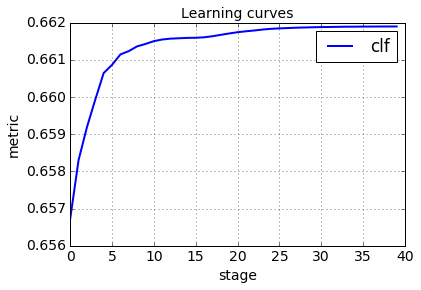

In [23]:
from rep.report.metrics import RocAuc
report.learning_curve(RocAuc(), steps=1)

In [18]:
from sklearn.metrics import roc_auc_score
print 'track', roc_auc_score(Bdata.Bsign > 0, Bdata.track_relation_prob / (1 + Bdata.track_relation_prob))
print 'vertex', roc_auc_score(Bdata.Bsign > 0, Bdata.vertex_relation_prob / (1 + Bdata.vertex_relation_prob))
print 'combining', roc_auc_score(Bdata.Bsign > 0, p)
print 'simple combining', roc_auc_score(Bdata.Bsign > 0, Bprob)

track 0.660862887523
vertex 0.551841347333
combining 0.661860948122
simple combining 0.660843821423


In [24]:
from sklearn.metrics import roc_auc_score
print 'track', roc_auc_score(Bdata_m.Bsign > 0, Bdata_m.track_relation_prob / (1 + Bdata_m.track_relation_prob))
print 'vertex', roc_auc_score(Bdata_m.Bsign > 0, Bdata_m.vertex_relation_prob / (1 + Bdata_m.vertex_relation_prob))
print 'combining', roc_auc_score(Bdata_m.Bsign > 0, p)
print 'simple combining', roc_auc_score(Bdata_m.Bsign > 0, Bprob)

track 0.660862887523
vertex 0.54432901527
combining 0.661807677702
simple combining 0.660843821423


--------------------

## 2-folding calibration by isotonic

In [15]:
from utils import calibrate_probs
Bprob_calibrated, calibrator = calibrate_probs(Bsign, Bweight, Bprob, symmetrize=True)

In [47]:
Bprob_calibrated_m, _ = calibrate_probs(Bsign_m, Bweight_m, Bprob_m, symmetrize=True)

In [95]:
# Bprob_dt_calibrated, _ = calibrate_probs(Bsign, Bweight, p, logistic=True, symmetrize=True, return_calibrator=True)

In [17]:
Bprob_track_calibrated, _  = calibrate_probs(Bsign_track, Bweight_track, Bprob_track, symmetrize=True)

(<matplotlib.legend.Legend at 0x7f0d8f743990>,
 <matplotlib.text.Text at 0x7f0d8f765210>)

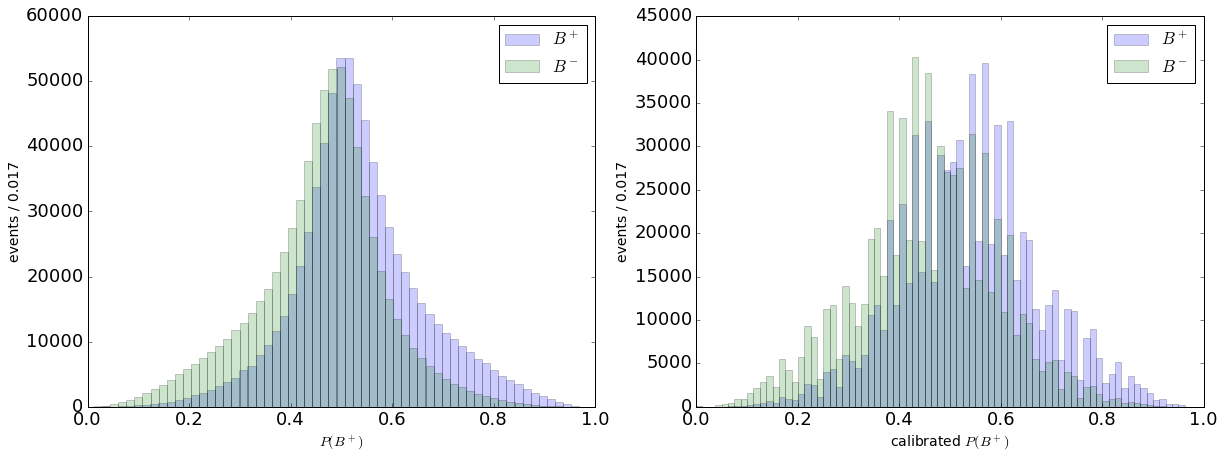

In [18]:
figure(figsize=(20, 7))

subplot(1,2,1)
hist(Bprob[Bsign == 1], weights=Bweight[Bsign == 1], bins=60, alpha=0.2,  label='$B^+$')
hist(Bprob[Bsign == -1], weights=Bweight[Bsign == -1], bins=60, alpha=0.2,  label='$B^-$')
legend(), xlabel('$P(B^+)$'), ylabel('events / 0.017')
xticks(fontsize=18), yticks(fontsize=18)
subplot(1,2,2)
hist(Bprob_calibrated[Bsign == 1], weights=Bweight[Bsign == 1], bins=80, alpha=0.2, 
      range=(0, 1), label='$B^+$')
hist(Bprob_calibrated[Bsign == -1], weights=Bweight[Bsign == -1], bins=80, alpha=0.2,
      range=(0, 1), label='$B^-$')
ylim(0, )
xticks(fontsize=18), yticks(fontsize=18)
legend(), xlabel('calibrated $P(B^+)$'), ylabel('events / 0.017')
# plt.savefig('img/Bprob_iso_calibrated_PID_less.png' , format='png')
# plt.savefig('img/paper_B_prob.png', dpi=300, format='png', bbox_inches='tight')

## AUC score and ROC curve for B+ vs B-

In [19]:
import json
with open('models/JPsiKMC.json', 'r') as f:
    N_B = json.load(f)['N_B_events']
N_B

1488891.0

AUC for tagged: 0.660771798463 AUC with untag: 0.660771411148


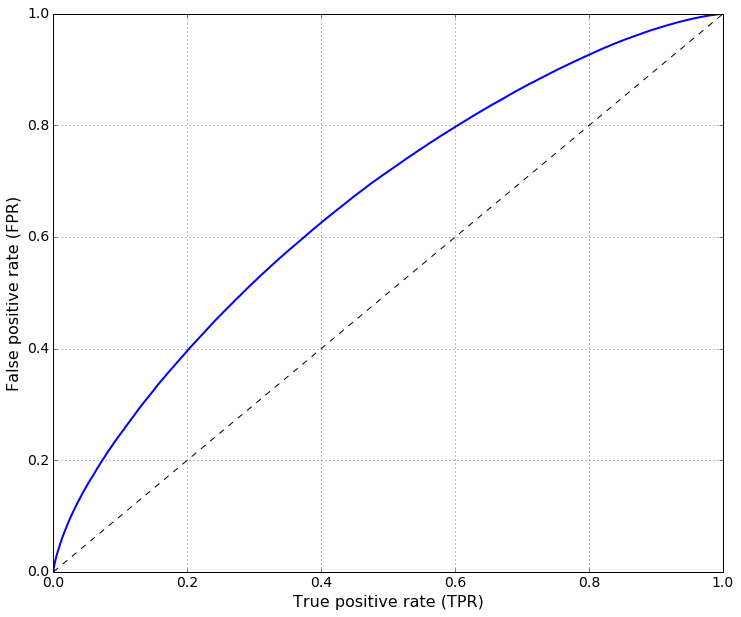

In [20]:
from utils import calculate_auc_with_and_without_untag_events, calculate_roc_with_untag_events
from sklearn.metrics import roc_curve

auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprob_calibrated, Bweight, N_B)
print 'AUC for tagged:', auc, 'AUC with untag:', auc_full

figure(figsize=(12, 10))
fpr, tpr, _ = calculate_roc_with_untag_events(Bsign, Bprob_calibrated, Bweight, N_B)
plot(fpr, tpr, linewidth=2)
plot([0, 1], [0, 1], 'k--')
ylim(0, 1), xlim(0, 1)
xlabel('True positive rate (TPR)', fontsize=16)
ylabel('False positive rate (FPR)', fontsize=16)
grid()
# plt.savefig('img/poster_B_roc.png' , dpi=700, format='png', transparent=True)

AUC for tagged: 0.658025425256 AUC with untag: 0.658025048986


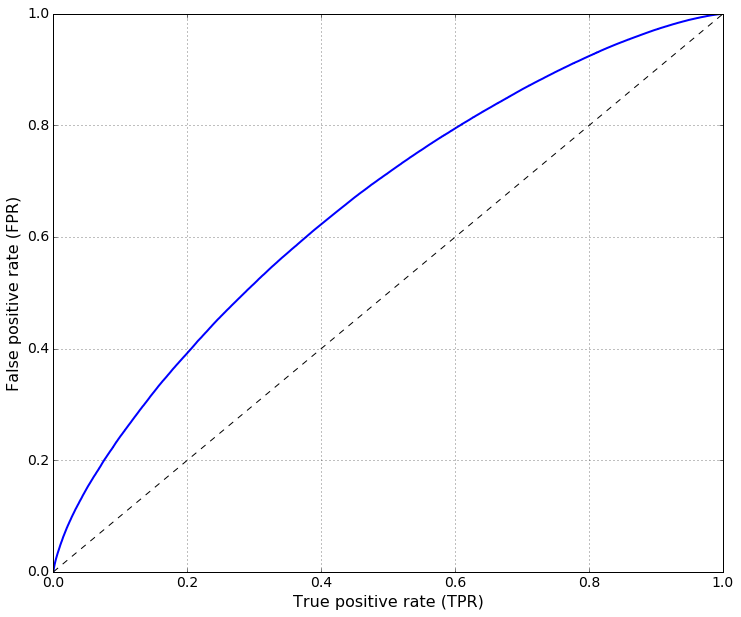

In [21]:
auc_m, auc_full_m = calculate_auc_with_and_without_untag_events(Bsign_m, Bprob_calibrated_m, Bweight_m, N_B)
print 'AUC for tagged:', auc_m, 'AUC with untag:', auc_full_m

figure(figsize=(12, 10))
fpr, tpr, _ = calculate_roc_with_untag_events(Bsign_m, Bprob_calibrated_m, Bweight_m, N_B)
plot(fpr, tpr, linewidth=2)
plot([0, 1], [0, 1], 'k--')
ylim(0, 1), xlim(0, 1)
xlabel('True positive rate (TPR)', fontsize=16)
ylabel('False positive rate (FPR)', fontsize=16)
grid()
# plt.savefig('img/poster_B_roc.png' , dpi=700, format='png', transparent=True)

## Symmetry $B^+$ vs $B^-$ checking

### before calibration

(<matplotlib.legend.Legend at 0x7f0db480d550>,
 <matplotlib.text.Text at 0x7f0d8c08aed0>)

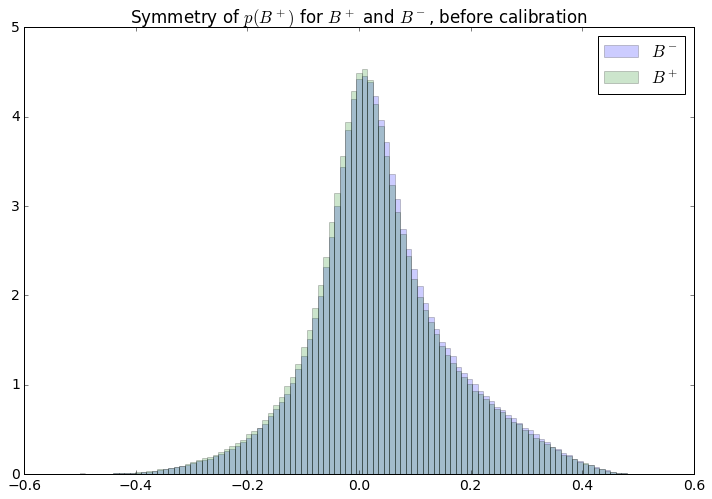

In [22]:
figsize(12, 8)
for sign in [-1, 1]:
    hist(sign * (Bprob[Bsign == sign] - 0.5), bins=101, normed=True, alpha=0.2, 
         weights=Bweight[Bsign == sign], range=(-0.5, 0.5), label='$B^-$' if sign == -1 else '$B^+$')
legend(), title('Symmetry of $p(B^+)$ for $B^+$ and $B^-$, before calibration')

#### KS distance

In [23]:
fpr, tpr, _ = roc_curve(Bsign, (Bprob - 0.5) * Bsign, sample_weight=Bweight)

In [24]:
'KS distance', max(abs(fpr - tpr))

('KS distance', 0.020418151729876488)

((0, 1), (0, 1))

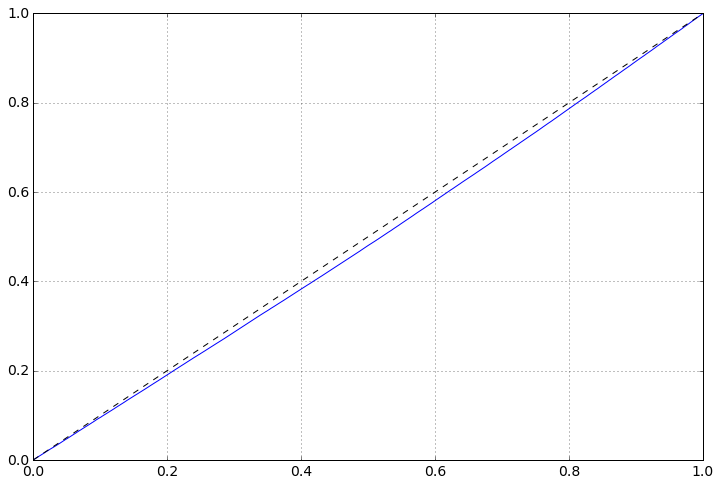

In [25]:
plot(fpr, tpr), grid()
plot([0, 1], [0, 1], 'k--')
xlim(0, 1), ylim(0, 1)

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Bsign, (Bprob - 0.5) * Bsign, sample_weight=Bweight)

0.48761221490715206

### after calibration

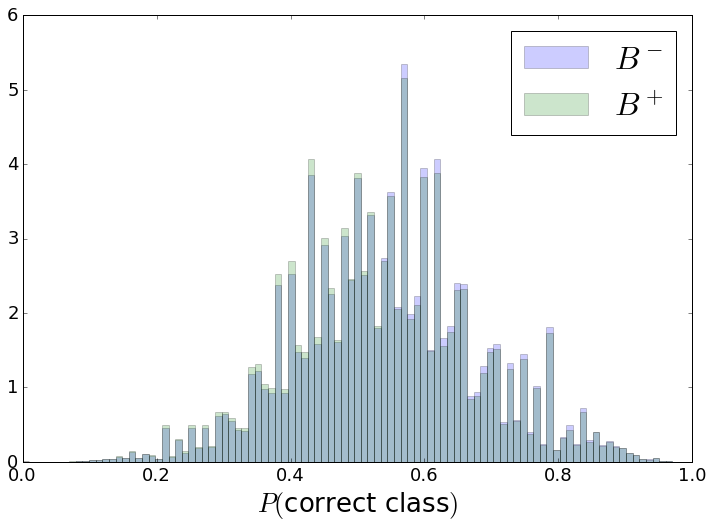

In [27]:
figsize(12, 8)
for sign in [-1, 1]:
    hist(sign * (Bprob_calibrated[Bsign == sign] - 0.5) + 0.5, bins=101,  alpha=0.2,
         weights=Bweight[Bsign == sign], range=(0, 1), normed=True, label='$B^-$' if sign == -1 else '$B^+$')
legend(fontsize=32); ylim(0, ), xlim(0, 1)
xticks(fontsize=18), yticks(fontsize=18)
xlabel('$P($correct class$)$', fontsize=26)
# plt.savefig('img/paper_symmetry.png' , dpi=300, format='png',  bbox_inches='tight')

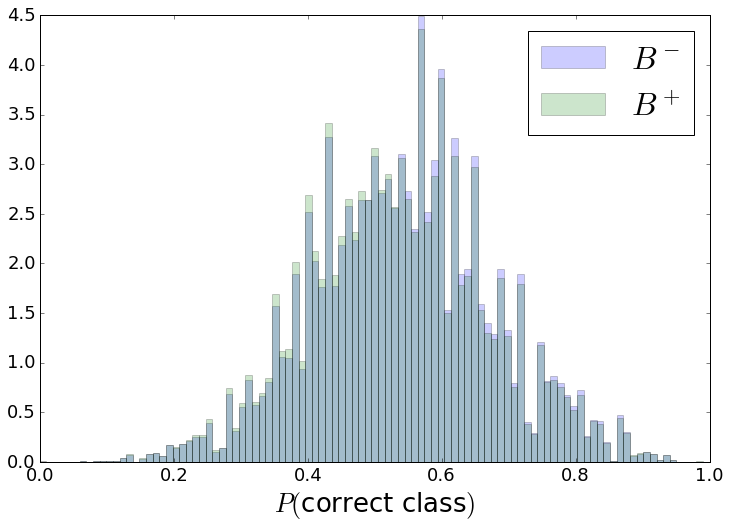

In [28]:
figsize(12, 8)
for sign in [-1, 1]:
    hist(sign * (Bprob_calibrated_m[Bsign_m == sign] - 0.5) + 0.5, bins=101,  alpha=0.2,
         weights=Bweight_m[Bsign_m == sign], range=(0, 1), normed=True, label='$B^-$' if sign == -1 else '$B^+$')
legend(fontsize=32); ylim(0, ), xlim(0, 1)
xticks(fontsize=18), yticks(fontsize=18)
xlabel('$P($correct class$)$', fontsize=26)
# plt.savefig('img/paper_symmetry.png' , dpi=300, format='png',  bbox_inches='tight')

#### KS distance

In [29]:
fpr, tpr, _ = roc_curve(Bsign, (Bprob_calibrated - 0.5) * Bsign, sample_weight=Bweight)

In [30]:
'KS distance', max(abs(fpr - tpr))

('KS distance', 0.020456171537568402)

((0, 1), (0, 1))

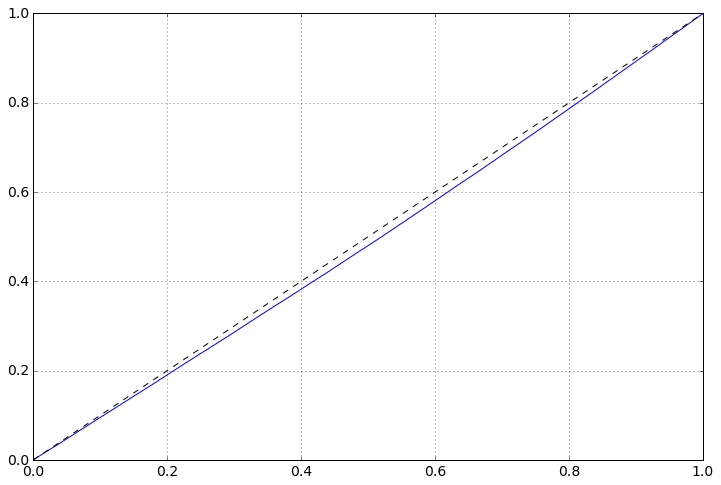

In [31]:
plot(fpr, tpr), grid()
plot([0, 1], [0, 1], 'k--')
xlim(0, 1), ylim(0, 1)

In [32]:
roc_auc_score(Bsign, (Bprob_calibrated - 0.5) * Bsign, sample_weight=Bweight)

0.48758922783790837

In [33]:
roc_auc_score(Bsign_m, (Bprob_calibrated_m - 0.5) * Bsign_m, sample_weight=Bweight_m)

0.48798831746738469

## D2 estimation with bootstrap calibration

In [33]:
from utils import result_table

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


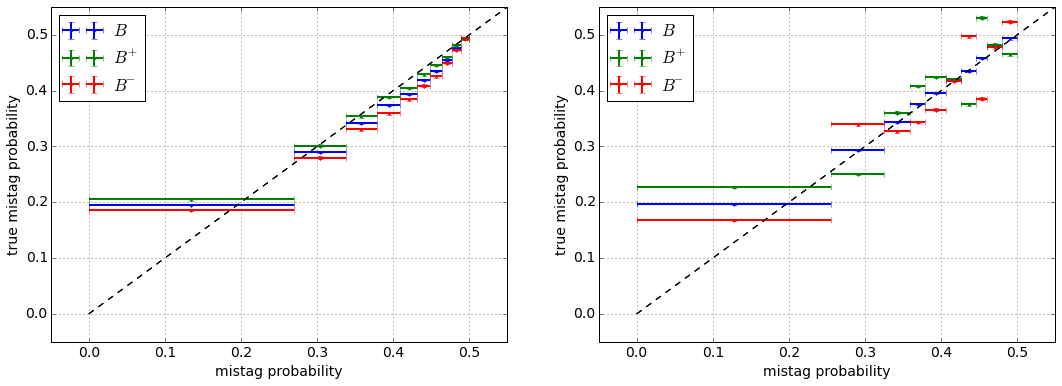

AUC 0.660743017599 3.13630068372e-07


In [34]:
from utils import get_N_B_events, bootstrap_calibrate_prob, result_table

N_B_passed = Bweight.sum()
tagging_efficiency = N_B_passed / N_B
tagging_efficiency_delta = numpy.sqrt(N_B_passed) / N_B

D2, aucs = bootstrap_calibrate_prob(Bsign, Bweight, Bprob, symmetrize=True, n_calibrations=30)
print 'AUC', numpy.mean(aucs), numpy.var(aucs)

result = result_table(tagging_efficiency, tagging_efficiency_delta, D2, auc_full, 'Inclusive tagging (track+vertex)')

In [ ]:
D2, aucs = bootstrap_calibrate_prob(Bsign_m, Bweight_m, Bprob_m, symmetrize=True, n_calibrations=30)
print 'AUC', numpy.mean(aucs), numpy.var(aucs)

result_m = result_table(tagging_efficiency, tagging_efficiency_delta, D2, auc_full_m, 'Inclusive tagging (track+vertex) new vertex')

In [61]:
pandas.concat([result, result_m1])

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,Inclusive tagging (track+vertex),99.999597,0.081954,0.082225,0.000529,8.222484,0.053368,66.077232,0
0,Inclusive tagging (track+vertex) new vertex,99.999597,0.081954,0.079014,0.000000,7.901330,0.006475,65.803377,0


In [36]:
pandas.concat([result, result_m])

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,Inclusive tagging (track+vertex),99.999597,0.081954,0.082225,0.000529,8.222484,0.053368,66.077232,0
0,Inclusive tagging (track+vertex) new vertex,99.999597,0.081954,0.076154,0.000373,7.615376,0.037837,65.803377,0


In [45]:
pandas.concat([result, result_dt, result_track])

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,Inclusive tagging (track+vertex),99.999597,0.081954,0.082146,0.000448,8.214555,0.045288,66.077742,0.000000
0,Inclusive tagging (track+vertex) dt,99.999597,0.081954,0.083210,0.000340,8.320980,0.034664,66.184030,0.000000
0,Inclusive tagging (track+vertex) track,99.999597,0.081954,0.081875,0.000333,8.187482,0.033944,66.085333,0.000019


## Some plots

### Isotonic transformation, and its reverse (too check symmetry)

(<matplotlib.text.Text at 0x7fa7285ac3d0>,
 <matplotlib.text.Text at 0x7fa7283c7d90>)

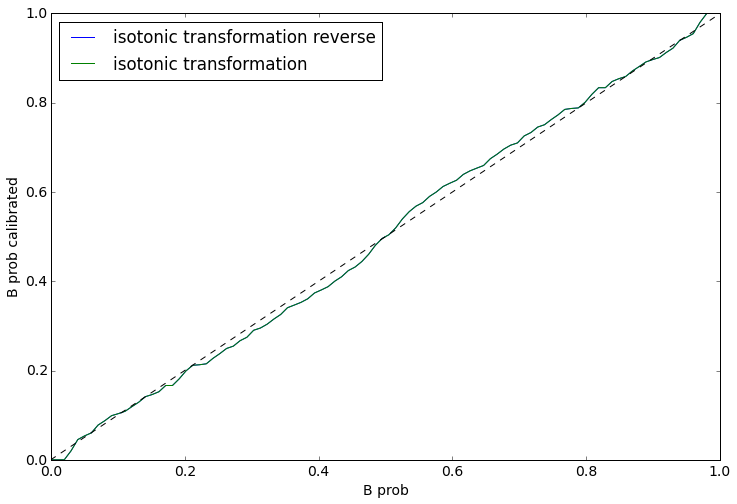

In [37]:
x = numpy.linspace(0, 1, 100)
plot(x, -(iso_reg1.transform((1-x)) + iso_reg2.transform((1-x))) / 2 + 1, label='isotonic transformation reverse')
plot(x, (iso_reg1.transform(x) + iso_reg2.transform(x)) / 2, label='isotonic transformation')
legend(loc='best')
plot([0, 1], [0, 1], "k--")
xlabel('B prob'), ylabel('B prob calibrated')
# plt.savefig('img/iso_transformation_PID_less.png' , format='png')

### Mistag checking

In [34]:
from utils import get_N_B_events, compute_mistag

In [35]:
bins = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
percentile_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]

### before calibration

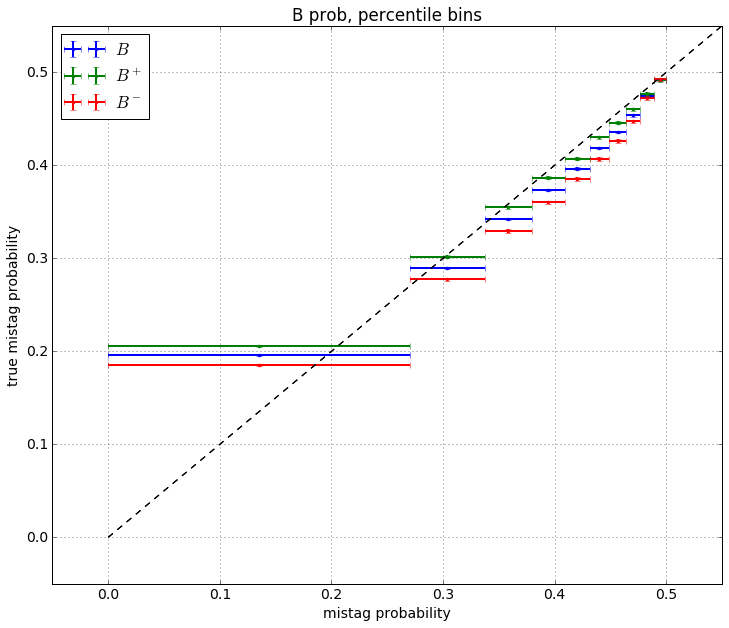

In [36]:
figsize(12, 10)
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob, percentile bins')

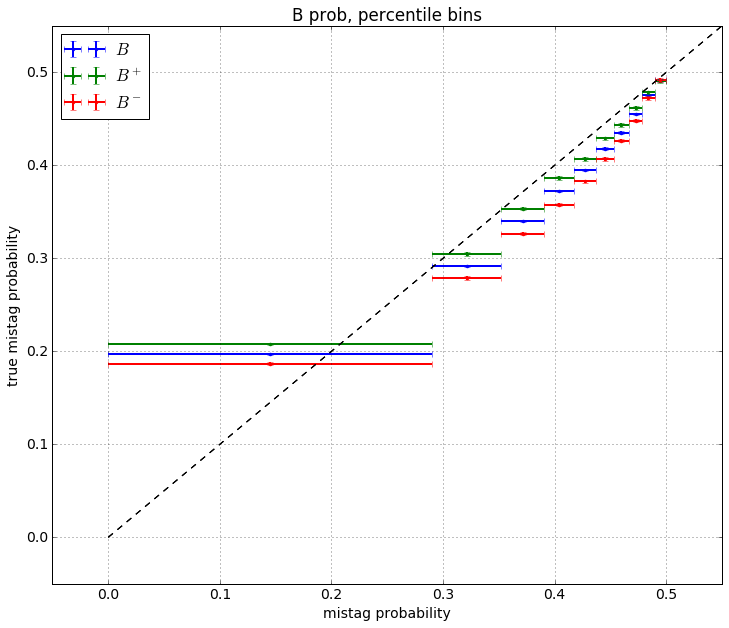

In [37]:
figsize(12, 10)
compute_mistag(Bprob_track, Bsign_track, Bweight_track, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_track, Bsign_track, Bweight_track, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_track, Bsign_track, Bweight_track, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob, percentile bins')

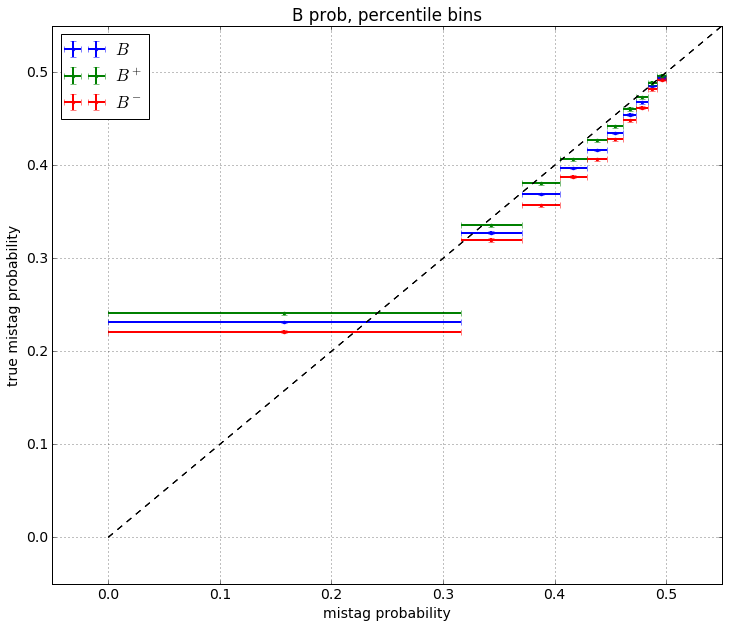

In [48]:
figsize(12, 10)
compute_mistag(Bprob_m, Bsign_m, Bweight_m, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_m, Bsign_m, Bweight_m, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_m, Bsign_m, Bweight_m, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob, percentile bins')

### after calibration

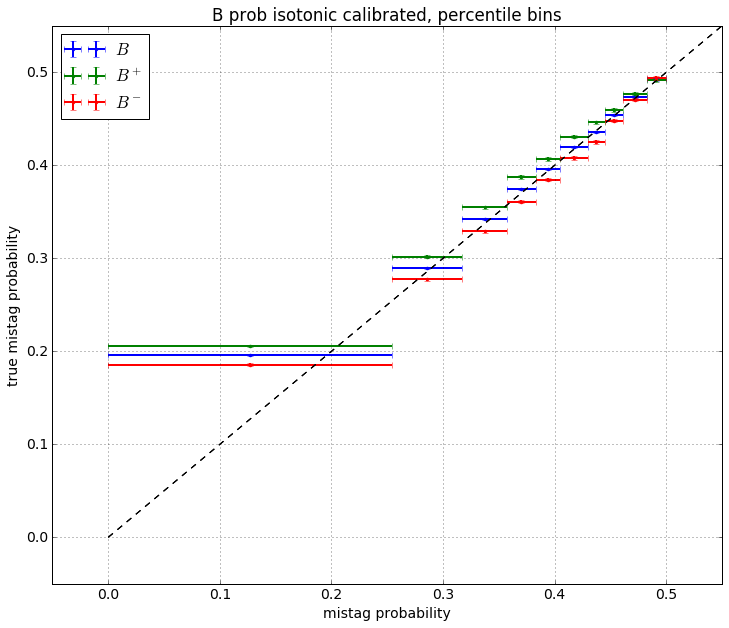

In [39]:
figsize(12, 10)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob isotonic calibrated, percentile bins')

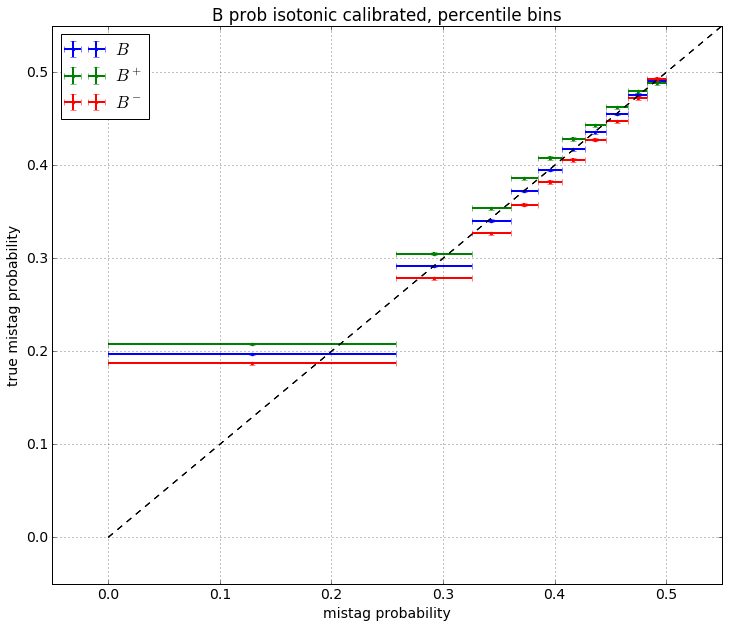

In [40]:
figsize(12, 10)
compute_mistag(Bprob_track_calibrated, Bsign_track, Bweight_track, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_track_calibrated, Bsign, Bweight_track, Bsign_track == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_track_calibrated, Bsign, Bweight_track, Bsign_track == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob isotonic calibrated, percentile bins')

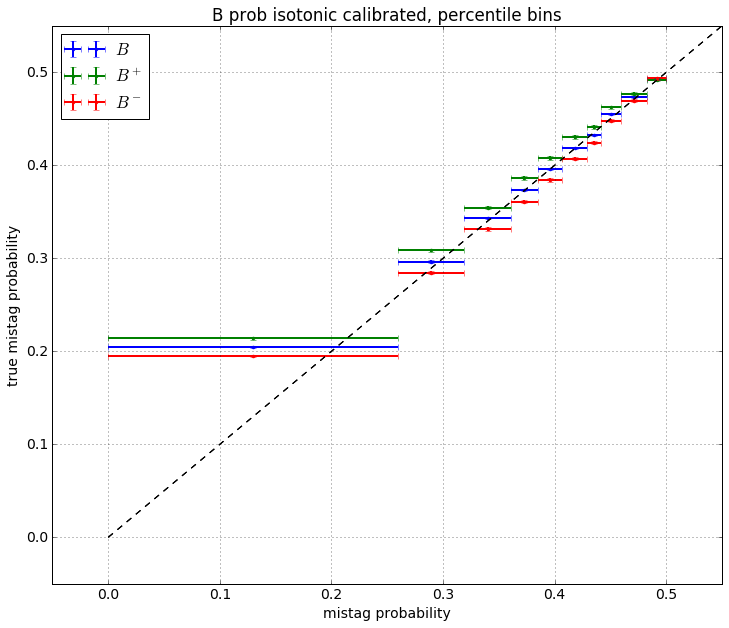

In [41]:
figsize(12, 10)
compute_mistag(Bprob_calibrated_m, Bsign_m, Bweight_m, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated_m, Bsign_m, Bweight_m, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated_m, Bsign_m, Bweight_m, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob isotonic calibrated, percentile bins')

-----------------

In [43]:
N_B_passed = Bweight.sum()
tagging_efficiency = N_B_passed / N_B
tagging_efficiency_delta = numpy.sqrt(N_B_passed) / N_B

In [49]:
print numpy.average((2*(Bprob_calibrated - 0.5))**2, weights=Bweight) * tagging_efficiency * 100
print numpy.average((2*(Bprob_calibrated_m - 0.5))**2, weights=Bweight_m) * tagging_efficiency * 100
print numpy.average((2*(Bprob_track_calibrated - 0.5))**2, weights=Bweight_track) * tagging_efficiency * 100

8.21404594861
5.92015228951
8.18910563248


In [50]:
roc_auc_score(Bsign_m, Bprob_calibrated_m, sample_weight=Bweight_m)

0.63438856700264379

In [37]:
print numpy.average((2*(Bprob - 0.5))**2, weights=Bweight) * tagging_efficiency * 100
print numpy.average((2*(Bprob_calibrated - 0.5))**2, weights=Bweight) * tagging_efficiency * 100

6.13125823299
7.54889068092
